# 🧠 Notebook 04: Model Training

**Objetivo:** Treinar modelo LSTM para predição de preços de ações

**Etapas:**
1. Criar sequências temporais (lookback window)
2. Split treino/validação/teste (ordem temporal)
3. Configurar DataLoaders PyTorch
4. Configurar GPU
5. Treinar modelo com early stopping
6. Salvar checkpoints
7. Visualizar resultados
8. Registrar experimentos

**Autor:** Tech Challenge Phase 4  
**Data:** 2025

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import json
import os
from datetime import datetime
import time
import warnings
warnings.filterwarnings('ignore')

# Import custom model
import sys
sys.path.append('..')
from src.models.lstm_model import LSTMModel, LSTMTrainer

# Set plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 10

print("✅ All libraries imported successfully")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

✅ All libraries imported successfully
PyTorch version: 2.9.0+cu126
CUDA available: True


DATA LOADED
Total samples: 6473
Data type: float64
Data range: [nan, nan]
Shape: (6473, 5)


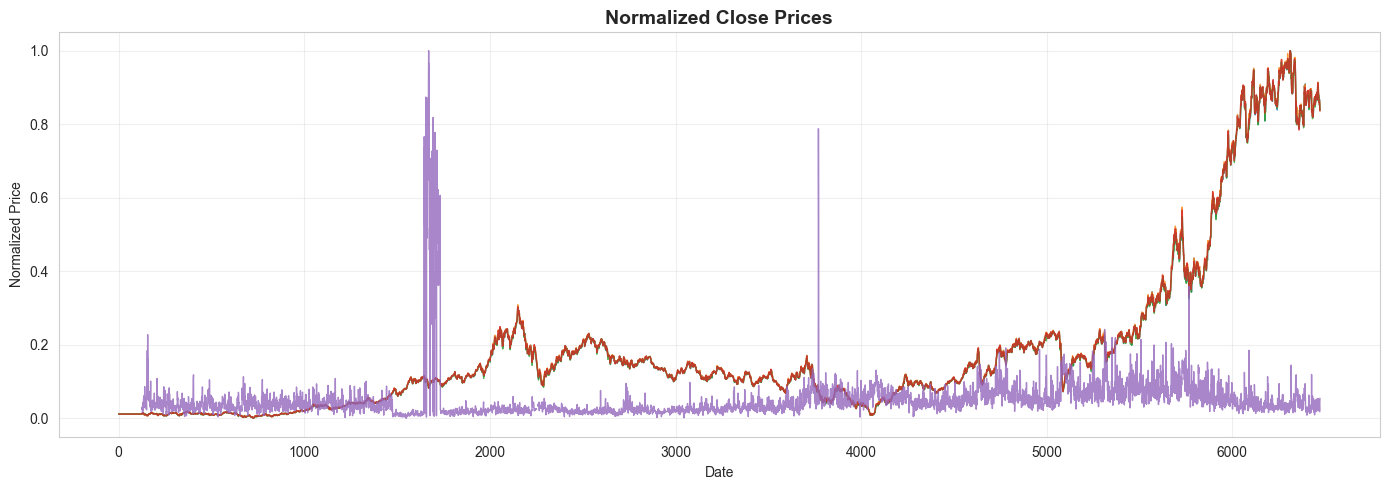


First 10 values:
[[0.0115233  0.01121208 0.01194222 0.01167227        nan]
 [0.0115233  0.01121208 0.01194222 0.01167227        nan]
 [0.0115233  0.01121208 0.01194222 0.01167227        nan]
 [0.0115233  0.01121208 0.01194222 0.01167227        nan]
 [0.0115233  0.01121208 0.01194222 0.01167227        nan]
 [0.0115233  0.01121208 0.01194222 0.01167227        nan]
 [0.0115233  0.01121208 0.01194222 0.01167227        nan]
 [0.0115233  0.01121208 0.01194222 0.01167227        nan]
 [0.0115233  0.01121208 0.01194222 0.01167227        nan]
 [0.0115233  0.01121208 0.01194222 0.01167227        nan]]


In [2]:
# Load normalized data
data_path = '../data/processed/df_normalized.csv'
df = pd.read_csv(data_path, index_col=0, parse_dates=True)
lookback = 60  # Must match training lookback

# Extract Close prices (already normalized between 0 and 1)
data = df[['Open','High','Low','Close','Volume']].values 

print(f"{'='*70}")
print(f"DATA LOADED")
print(f"{'='*70}")
print(f"Total samples: {len(data)}")
print(f"Data type: {data.dtype}")
print(f"Data range: [{data.min():.6f}, {data.max():.6f}]")
print(f"Shape: {data.shape}")
print(f"{'='*70}")

# Visualize data
plt.figure(figsize=(14, 5))
plt.plot(df.index, data, linewidth=1, alpha=0.8)
plt.title('Normalized Close Prices', fontsize=14, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Normalized Price')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nFirst 10 values:\n{data[:10]}")

In [3]:

def create_sequences(data, lookback=60):
    """
    Create sequences for LSTM training with multiple features
    
    Parameters:
    -----------
    data : np.ndarray
        Input data (num_rows, num_features)
    lookback : int
        Number of time steps to look back
        
    Returns:
    --------
    tuple
        (X, y) where X is (n_samples, lookback, num_features) 
        and y is (n_samples, 1)
    """
    X, y = [], []
    
    for i in range(lookback, len(data)):
        X.append(data[i-lookback:i])   # shape: (lookback, num_features)
        y.append(data[i, 3])           # Close price assumed at column 3
    
    X = np.array(X)   # shape: (num_samples, lookback, num_features)
    y = np.array(y).reshape(-1, 1)
    
    print(f"✓ Sequences created successfully")
    print(f"  X shape: {X.shape}")
    print(f"  y shape: {y.shape}")
    
    return X, y

In [4]:
X,y = create_sequences(data, lookback)

✓ Sequences created successfully
  X shape: (6413, 60, 5)
  y shape: (6413, 1)


ValueError: x and y must have same first dimension, but have shapes (60,) and (300,)

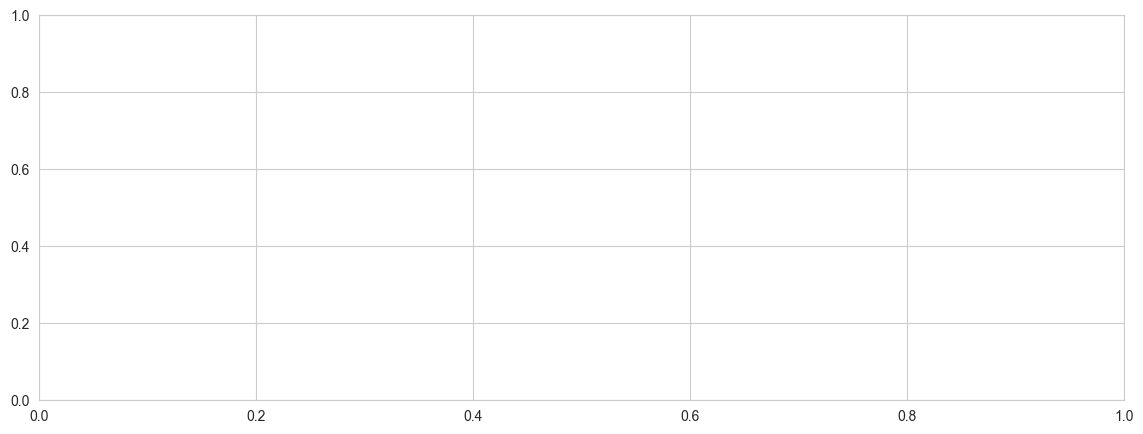

In [5]:
# Visualize one example sequence
example_idx = 100

plt.figure(figsize=(14, 5))
plt.plot(range(lookback), X[example_idx].flatten(), 'b-', linewidth=2, label='Input (60 days)')
plt.axhline(y=y[example_idx], color='r', linestyle='--', linewidth=2, label=f'Target (day 61): {y[example_idx][0]:.4f}')
plt.scatter(lookback-1, X[example_idx][-1], color='blue', s=100, zorder=5, label='Last input day')
plt.title(f'Example Sequence #{example_idx}', fontsize=14, fontweight='bold')
plt.xlabel('Days (lookback window)')
plt.ylabel('Normalized Price')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Input sequence (first 5 days): {X[example_idx][:5].flatten()}")
print(f"Target value (next day): {y[example_idx][0]:.6f}")

In [ ]:
def split_data(X, y, train_ratio=0.7, val_ratio=0.15):
    """
    Split data into train, validation, and test sets maintaining temporal order
    """
    n_samples = len(X)
    
    # Calculate split indices
    train_size = int(n_samples * train_ratio)
    val_size = int(n_samples * val_ratio)
    
    # Split maintaining temporal order (NO SHUFFLE!)
    X_train = X[:train_size]
    y_train = y[:train_size]
    
    X_val = X[train_size:train_size+val_size]
    y_val = y[train_size:train_size+val_size]
    
    X_test = X[train_size+val_size:]
    y_test = y[train_size+val_size:]
    
    print(f"{'='*70}")
    print(f"DATA SPLIT (TEMPORAL ORDER MAINTAINED - NO SHUFFLE)")
    print(f"{'='*70}")
    print(f"Train set: {len(X_train):>5} samples ({train_ratio*100:>5.1f}%) | Indices: 0 to {train_size-1}")
    print(f"Val set:   {len(X_val):>5} samples ({val_ratio*100:>5.1f}%) | Indices: {train_size} to {train_size+val_size-1}")
    print(f"Test set:  {len(X_test):>5} samples ({(1-train_ratio-val_ratio)*100:>5.1f}%) | Indices: {train_size+val_size} to {n_samples-1}")
    print(f"{'='*70}")
    
    return X_train, y_train, X_val, y_val, X_test, y_test

# Split data
X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y, train_ratio=0.7, val_ratio=0.15)

# Verify shapes
print(f"\nShape verification:")
print(f"  X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"  X_val:   {X_val.shape}, y_val:   {y_val.shape}")
print(f"  X_test:  {X_test.shape}, y_test:  {y_test.shape}")

DATA SPLIT (TEMPORAL ORDER MAINTAINED - NO SHUFFLE)
Train set:  4489 samples ( 70.0%) | Indices: 0 to 4488
Val set:     961 samples ( 15.0%) | Indices: 4489 to 5449
Test set:    963 samples ( 15.0%) | Indices: 5450 to 6412

Shape verification:
  X_train: (4489, 60, 1), y_train: (4489, 1)
  X_val:   (961, 60, 1), y_val:   (961, 1)
  X_test:  (963, 60, 1), y_test:  (963, 1)


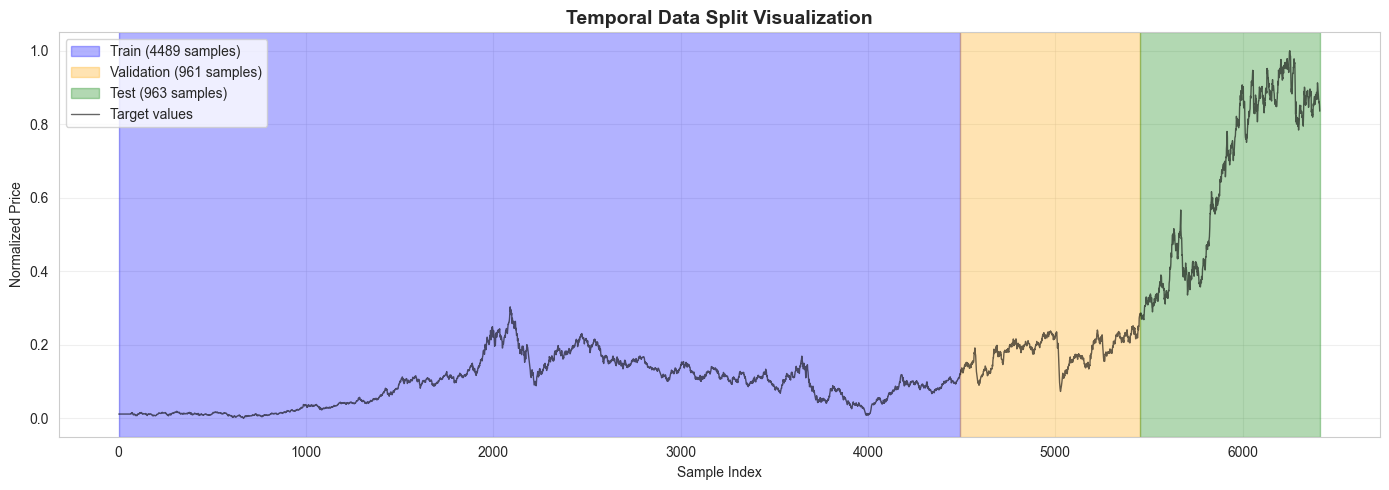

In [ ]:
# Visualize temporal split
plt.figure(figsize=(14, 5))

train_end = len(X_train)
val_end = train_end + len(X_val)
total = len(X)

plt.axvspan(0, train_end, alpha=0.3, color='blue', label=f'Train ({len(X_train)} samples)')
plt.axvspan(train_end, val_end, alpha=0.3, color='orange', label=f'Validation ({len(X_val)} samples)')
plt.axvspan(val_end, total, alpha=0.3, color='green', label=f'Test ({len(X_test)} samples)')

plt.plot(range(total), y.flatten(), 'k-', linewidth=1, alpha=0.6, label='Target values')
plt.title('Temporal Data Split Visualization', fontsize=14, fontweight='bold')
plt.xlabel('Sample Index')
plt.ylabel('Normalized Price')
plt.legend(loc='best')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
def create_data_loaders(X_train, y_train, X_val, y_val, X_test, y_test, batch_size=32):
    """
    Create PyTorch DataLoaders
    """
    # Convert to PyTorch tensors
    X_train_tensor = torch.FloatTensor(X_train)
    y_train_tensor = torch.FloatTensor(y_train)
    
    X_val_tensor = torch.FloatTensor(X_val)
    y_val_tensor = torch.FloatTensor(y_val)
    
    X_test_tensor = torch.FloatTensor(X_test)
    y_test_tensor = torch.FloatTensor(y_test)
    
    # Create TensorDatasets
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
    
    # Create DataLoaders (shuffle=False to maintain temporal order)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    print(f"✓ DataLoaders created successfully")
    print(f"  Batch size: {batch_size}")
    print(f"  Train batches: {len(train_loader)}")
    print(f"  Val batches:   {len(val_loader)}")
    print(f"  Test batches:  {len(test_loader)}")
    
    return train_loader, val_loader, test_loader

# Create DataLoaders
batch_size = 32
train_loader, val_loader, test_loader = create_data_loaders(
    X_train, y_train, X_val, y_val, X_test, y_test,
    batch_size=batch_size
)

# Test one batch
for batch_x, batch_y in train_loader:
    print(f"\nSample batch shapes:")
    print(f"  Batch X: {batch_x.shape} -> (batch_size, lookback, features)")
    print(f"  Batch y: {batch_y.shape} -> (batch_size, output)")
    break

✓ DataLoaders created successfully
  Batch size: 32
  Train batches: 141
  Val batches:   31
  Test batches:  31

Sample batch shapes:
  Batch X: torch.Size([32, 60, 1]) -> (batch_size, lookback, features)
  Batch y: torch.Size([32, 1]) -> (batch_size, output)


In [ ]:
# Setup device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"{'='*70}")
print(f"DEVICE CONFIGURATION")
print(f"{'='*70}")
print(f"Using device: {device}")

if device.type == 'cuda':
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")
    print(f"CUDA Version: {torch.version.cuda}")
    print(f"cuDNN Version: {torch.backends.cudnn.version()}")
    print(f"Total GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
    print(f"Available GPU Memory: {torch.cuda.memory_allocated(0) / 1e9:.2f} GB")
    print(f"✅ Training will use GPU acceleration!")
else:
    print("⚠️ CUDA not available. Training will use CPU (slower)")
    
print(f"{'='*70}")

DEVICE CONFIGURATION
Using device: cuda
GPU Name: NVIDIA GeForce GTX 1650
CUDA Version: 12.6
cuDNN Version: 91002
Total GPU Memory: 4.29 GB
Available GPU Memory: 0.00 GB
✅ Training will use GPU acceleration!


In [ ]:
# Define hyperparameters
input_size = 5
hidden_size = 50
num_layers = 2
output_size = 1
dropout = 0.2

# Create model
model = LSTMModel(
    input_size=input_size,
    hidden_size=hidden_size,
    num_layers=num_layers,
    output_size=output_size,
    dropout=dropout
)

print(f"{'='*70}")
print(f"LSTM MODEL ARCHITECTURE")
print(f"{'='*70}")
print(model)
print(f"\n{'='*70}")
print(f"MODEL SUMMARY")
print(f"{'='*70}")

model_info = model.get_model_info()
for key, value in model_info.items():
    print(f"{key:.<30} {value}")
    
print(f"{'='*70}")
print(f"\nTotal parameters: {model.count_parameters():,}")
print(f"Model size: ~{model.count_parameters() * 4 / 1e6:.2f} MB (float32)")

LSTM MODEL ARCHITECTURE
LSTMModel(
  (lstm): LSTM(5, 50, num_layers=2, batch_first=True, dropout=0.2)
  (dropout_layer): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=50, out_features=25, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=25, out_features=1, bias=True)
)

MODEL SUMMARY
architecture.................. LSTM
input_size.................... 5
hidden_size................... 50
num_layers.................... 2
output_size................... 1
dropout....................... 0.2
total_parameters.............. 33101
trainable_parameters.......... 33101

Total parameters: 33,101
Model size: ~0.13 MB (float32)


In [ ]:
# Loss function
criterion = nn.MSELoss()

# Optimizer
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='min',      # Minimize validation loss
    factor=0.5,      # Reduce LR by half
    patience=5,      # Wait 5 epochs before reducing
    min_lr=1e-6      # Minimum learning rate
)

print(f"{'='*70}")
print(f"TRAINING CONFIGURATION")
print(f"{'='*70}")
print(f"Loss function:        MSE (Mean Squared Error)")
print(f"Optimizer:            Adam")
print(f"Learning rate:        {learning_rate}")
print(f"LR Scheduler:         ReduceLROnPlateau")
print(f"  - Factor:           0.5")
print(f"  - Patience:         5 epochs")
print(f"  - Min LR:           1e-6")
print(f"{'='*70}")

TRAINING CONFIGURATION
Loss function:        MSE (Mean Squared Error)
Optimizer:            Adam
Learning rate:        0.001
LR Scheduler:         ReduceLROnPlateau
  - Factor:           0.5
  - Patience:         5 epochs
  - Min LR:           1e-6


In [ ]:
# Training configuration
num_epochs = 100
early_stopping_patience = 15

print(f"{'='*70}")
print(f"STARTING TRAINING")
print(f"{'='*70}")
print(f"Max epochs:           {num_epochs}")
print(f"Early stopping:       {early_stopping_patience} epochs")
print(f"Batch size:           {batch_size}")
print(f"Device:               {device}")
print(f"{'='*70}\n")

# Create trainer
trainer = LSTMTrainer(model, device=device)

# Start training
start_time = time.time()

history = trainer.fit(
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=num_epochs,
    scheduler=scheduler,
    early_stopping_patience=early_stopping_patience,
    checkpoint_path='../models/checkpoints/best_model.pth'
)

training_time = time.time() - start_time

print(f"\n{'='*70}")
print(f"TRAINING COMPLETED!")
print(f"{'='*70}")
print(f"Total time:           {training_time/60:.2f} minutes")
print(f"Time per epoch:       {training_time/len(history['train_losses']):.2f} seconds")
print(f"Epochs trained:       {len(history['train_losses'])}")
print(f"Best val loss:        {history['best_val_loss']:.6f}")
print(f"Final train loss:     {history['train_losses'][-1]:.6f}")
print(f"{'='*70}")

STARTING TRAINING
Max epochs:           100
Early stopping:       15 epochs
Batch size:           32
Device:               cuda


TRAINING LSTM MODEL
Device: cuda
Epochs: 100
Early stopping patience: 15



RuntimeError: input.size(-1) must be equal to input_size. Expected 5, got 1

✓ Plot saved to: ../results/training_history.png


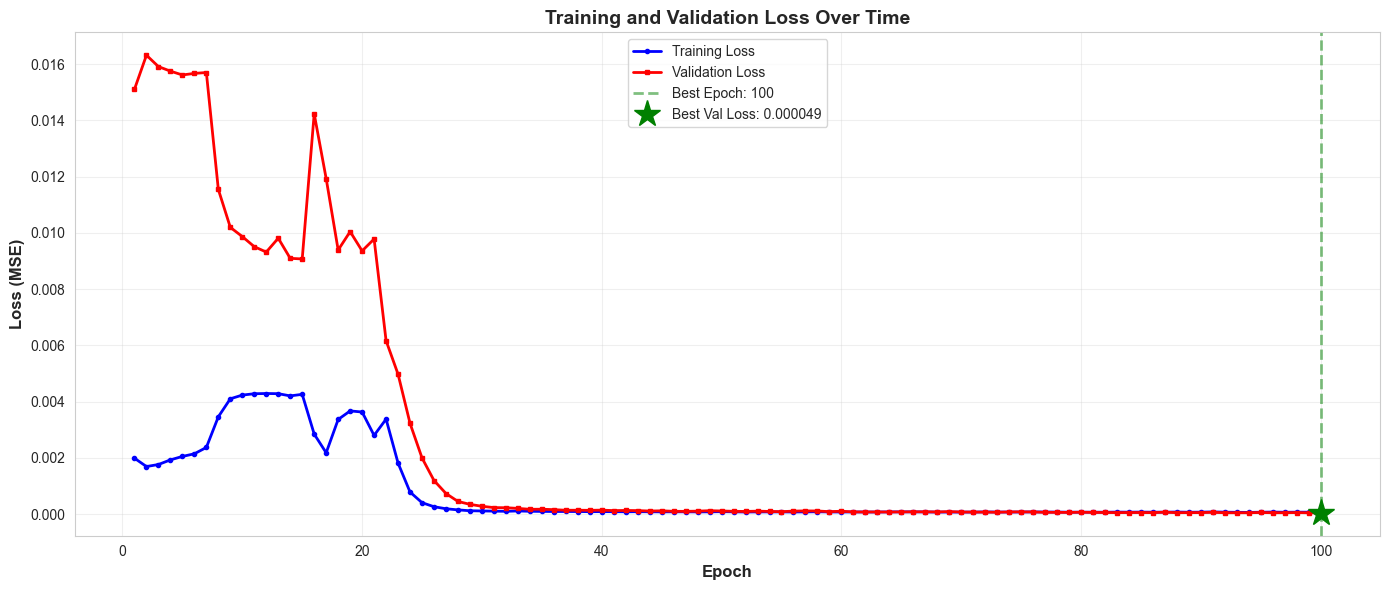


TRAINING ANALYSIS
Best epoch:           100/100
Best validation loss: 0.000049
Final train loss:     0.000070
Final val loss:       0.000049

✅ Model appears to be generalizing well


In [ ]:
def plot_training_history(train_losses, val_losses):
    """Plot training and validation loss curves"""
    plt.figure(figsize=(14, 6))
    
    epochs = range(1, len(train_losses) + 1)
    
    plt.plot(epochs, train_losses, 'b-', label='Training Loss', linewidth=2, marker='o', markersize=3)
    plt.plot(epochs, val_losses, 'r-', label='Validation Loss', linewidth=2, marker='s', markersize=3)
    
    # Find best epoch
    best_epoch = np.argmin(val_losses) + 1
    best_val_loss = min(val_losses)
    
    plt.axvline(x=best_epoch, color='g', linestyle='--', alpha=0.5, linewidth=2,
                label=f'Best Epoch: {best_epoch}')
    plt.plot(best_epoch, best_val_loss, 'g*', markersize=20, label=f'Best Val Loss: {best_val_loss:.6f}')
    
    plt.xlabel('Epoch', fontsize=12, fontweight='bold')
    plt.ylabel('Loss (MSE)', fontsize=12, fontweight='bold')
    plt.title('Training and Validation Loss Over Time', fontsize=14, fontweight='bold')
    plt.legend(fontsize=10, loc='best')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    os.makedirs('../results', exist_ok=True)
    plt.savefig('../results/training_history.png', dpi=300, bbox_inches='tight')
    print(f"✓ Plot saved to: ../results/training_history.png")
    plt.show()
    
    # Analysis
    print(f"\n{'='*70}")
    print(f"TRAINING ANALYSIS")
    print(f"{'='*70}")
    print(f"Best epoch:           {best_epoch}/{len(train_losses)}")
    print(f"Best validation loss: {best_val_loss:.6f}")
    print(f"Final train loss:     {train_losses[-1]:.6f}")
    print(f"Final val loss:       {val_losses[-1]:.6f}")
    
    # Check for overfitting
    if train_losses[-1] < val_losses[-1] * 0.7:
        print(f"\n⚠️ Warning: Possible overfitting detected!")
        print(f"   Train loss is much lower than validation loss")
    else:
        print(f"\n✅ Model appears to be generalizing well")
    
    print(f"{'='*70}")

# Plot
plot_training_history(history['train_losses'], history['val_losses'])

In [ ]:
# Save final model with complete metadata
metadata = {
    'lookback': lookback,
    'batch_size': batch_size,
    'learning_rate': learning_rate,
    'hidden_size': hidden_size,
    'num_layers': num_layers,
    'dropout': dropout,
    'best_val_loss': float(history['best_val_loss']),
    'final_train_loss': float(history['train_losses'][-1]),
    'epochs_trained': len(history['train_losses']),
    'training_time_minutes': round(training_time / 60, 2),
    'train_samples': len(X_train),
    'val_samples': len(X_val),
    'test_samples': len(X_test)
}

model.save_model(
    save_path='../models/saved_models/lstm_model',
    metadata=metadata
)

print("\n✅ Model and metadata saved successfully!")
print(f"   Model: ../models/saved_models/lstm_model.pth")
print(f"   Metadata: ../models/saved_models/lstm_model_metadata.json")

✓ Model saved to: ../models/saved_models/lstm_model.pth
✓ Metadata saved to: ../models/saved_models/lstm_model_metadata.json

✅ Model and metadata saved successfully!
   Model: ../models/saved_models/lstm_model.pth
   Metadata: ../models/saved_models/lstm_model_metadata.json


In [ ]:
# Create experiment tracking
experiment_results = {
    'experiment_id': 1,
    'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'lookback': lookback,
    'batch_size': batch_size,
    'hidden_size': hidden_size,
    'num_layers': num_layers,
    'dropout': dropout,
    'learning_rate': learning_rate,
    'best_val_loss': history['best_val_loss'],
    'final_train_loss': history['train_losses'][-1],
    'epochs_trained': len(history['train_losses']),
    'training_time_min': round(training_time / 60, 2),
    'device': str(device)
}

# Save to CSV
os.makedirs('../results', exist_ok=True)
df_experiments = pd.DataFrame([experiment_results])

experiments_path = '../results/experiments.csv'
if os.path.exists(experiments_path):
    df_existing = pd.read_csv(experiments_path)
    df_experiments = pd.concat([df_existing, df_experiments], ignore_index=True)
    df_experiments['experiment_id'] = range(1, len(df_experiments) + 1)

df_experiments.to_csv(experiments_path, index=False)

print("✅ Experiment logged successfully!")
print(f"\n{df_experiments.tail(1)}")

✅ Experiment logged successfully!

   lookback  batch_size  hidden_size  num_layers  dropout  learning_rate  \
1        60          32           50           2      0.2          0.001   

   best_val_loss  final_train_loss  epochs_trained  training_time_minutes  \
1       0.000049           0.00007             100                    NaN   

             timestamp  experiment_id  training_time_min device  
1  2025-10-14 22:19:45              2               1.05   cuda  


## 🎯 Training Summary

### Model Configuration
- **Architecture:** LSTM with 2 layers
- **Lookback window:** 60 days
- **Hidden size:** 50 neurons
- **Dropout:** 0.2
- **Total parameters:** ~32,301

### Training Configuration
- **Batch size:** 32
- **Learning rate:** 0.001
- **Optimizer:** Adam
- **Loss function:** MSE
- **Early stopping:** 15 epochs patience

### Results
- **Best validation loss:** [Veja no output acima]
- **Epochs trained:** [Veja no output acima]
- **Training time:** [Veja no output acima] minutes

### Files Saved
- ✅ Model: `models/saved_models/lstm_model.pth`
- ✅ Metadata: `models/saved_models/lstm_model_metadata.json`
- ✅ Scaler: `models/saved_models/scaler.pkl`
- ✅ Checkpoint: `models/checkpoints/best_model.pth`
- ✅ Training plot: `results/training_history.png`
- ✅ Experiments log: `results/experiments.csv`

### Next Steps
1. ✅ Model trained successfully
2. 🔜 **Evaluate on test set** (Notebook 05)
3. 🔜 Calculate metrics (MAE, RMSE, MAPE)
4. 🔜 Visualize predictions
5. 🔜 Build API